## Pathways Technologies Ltd Datathon - Copia Use Case
### Modeling price elasicity of Copia SKUs

In [91]:
# Import libraries
import numpy as np
import pandas as pd
import pandas_profiling
from scipy.stats import norm
import matplotlib.pyplot as plt
import statistics
from numpy import mean
from numpy import std
%matplotlib inline

## For spectral graph partitioning.
from sklearn.cluster import spectral_clustering as spc

## Supervised learning.
from sklearn import svm, linear_model, ensemble, neighbors, tree
from sklearn import metrics, preprocessing
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.datasets import make_classification

from collections import Counter

from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.classifier import Perceptron
from mlxtend.classifier import MultiLayerPerceptron as MLP


from sklearn.feature_selection import SelectKBest, f_regression

In [92]:
# Load the csv file with all SKUs into a pandas dataframe
df = pd.read_csv('../All_SKUs/All_SKUs.csv')
df.head()

Product_Code  Revenue_KES        Qty #_Customers Daily_Avg_Qty SP_Vat_Inc  \
0        KQ263  369,462,574  3,954,936     385,594     12,094.61     108.37   
1        KQ469  236,835,878  1,806,875     153,153      5,525.61     131.07   
2        KQ479  193,367,228  1,949,351     147,543      5,961.32       99.2   
3        KQ480  134,354,631  1,046,833     105,741      3,201.32     128.34   
4        KQ525   80,081,138     45,058      27,251        138.21   2,061.66   

  SP_Less_Vat BP_Less_Vat  
0       93.42       88.23  
1      131.07      128.41  
2        99.2       98.04  
3      128.34      125.79  
4    1,777.29    1,692.75

In [93]:
# Dataframe shape
df.shape

(229, 8)

In [94]:
#Dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229 entries, 0 to 228
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Product_Code   229 non-null    object
 1   Revenue_KES    229 non-null    object
 2   Qty            229 non-null    object
 3   #_Customers    229 non-null    object
 4   Daily_Avg_Qty  229 non-null    object
 5   SP_Vat_Inc     227 non-null    object
 6   SP_Less_Vat    227 non-null    object
 7   BP_Less_Vat    227 non-null    object
dtypes: object(8)
memory usage: 14.4+ KB


### Format column headers and column data type/format

In [95]:
df['Revenue_KES'] = df['Revenue_KES'].str.replace(',', '').astype(float)

In [96]:
df['Qty'] = df['Qty'].str.replace(',', '').astype(int)

In [97]:
df['#_Customers'] = df['#_Customers'].str.replace(',', '').astype(int)

In [98]:
df['Daily_Avg_Qty'] = df['Daily_Avg_Qty'].str.replace(',', '').astype(float)

In [99]:
df['SP_Vat_Inc'] = df['SP_Vat_Inc'].str.replace(',', '').astype(float)

In [100]:
df['SP_Less_Vat'] = df['SP_Less_Vat'].str.replace(',', '').astype(float)

In [101]:
df['BP_Less_Vat'] = df['BP_Less_Vat'].str.replace(',', '').astype(float)

In [102]:
#Dataframe info after column formating
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229 entries, 0 to 228
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Product_Code   229 non-null    object 
 1   Revenue_KES    229 non-null    float64
 2   Qty            229 non-null    int64  
 3   #_Customers    229 non-null    int64  
 4   Daily_Avg_Qty  229 non-null    float64
 5   SP_Vat_Inc     227 non-null    float64
 6   SP_Less_Vat    227 non-null    float64
 7   BP_Less_Vat    227 non-null    float64
dtypes: float64(5), int64(2), object(1)
memory usage: 14.4+ KB


In [103]:
#First 5 records
df.head()

Product_Code  Revenue_KES      Qty  #_Customers  Daily_Avg_Qty  SP_Vat_Inc  \
0        KQ263  369462574.0  3954936       385594       12094.61      108.37   
1        KQ469  236835878.0  1806875       153153        5525.61      131.07   
2        KQ479  193367228.0  1949351       147543        5961.32       99.20   
3        KQ480  134354631.0  1046833       105741        3201.32      128.34   
4        KQ525   80081138.0    45058        27251         138.21     2061.66   

   SP_Less_Vat  BP_Less_Vat  
0        93.42        88.23  
1       131.07       128.41  
2        99.20        98.04  
3       128.34       125.79  
4      1777.29      1692.75

In [104]:
# Description of numerical data in the df
df.describe()

Revenue_KES           Qty    #_Customers  Daily_Avg_Qty   SP_Vat_Inc  \
count  2.290000e+02  2.290000e+02     229.000000     229.000000   227.000000   
mean   7.491383e+06  6.025317e+04    6860.340611     215.928297   821.893789   
std    3.347675e+07  3.316085e+05   30268.569755    1015.808215  1140.723693   
min    0.000000e+00  0.000000e+00       1.000000       0.000000    37.000000   
25%    1.585990e+05  2.850000e+02     174.000000       5.110000   129.095000   
50%    5.377280e+05  1.675000e+03     822.000000      16.500000   246.300000   
75%    2.655201e+06  1.013000e+04    3291.000000      68.570000  1104.170000   
max    3.694626e+08  3.954936e+06  385594.000000   12094.610000  6127.420000   

       SP_Less_Vat  BP_Less_Vat  
count   227.000000   227.000000  
mean    732.670441   693.117225  
std    1002.996351   970.572100  
min      34.340000    28.570000  
25%     116.815000   105.140000  
50%     215.690000   197.530000  
75%     951.870000   847.935000  
max    5282.260000  5208.520000

### Data Profiling
pandas-profiling generates profile reports from a pandas DataFrame. This automatically generates a standardized univariate and multivariate report for data understanding.
The report contains three additional sections:

>Overview: mostly global details about the dataset (number of records, number of variables, overall missigness and duplicates, memory footprint)

>Alerts: a comprehensive and automatic list of potential data quality issues (high correlation, skewness, uniformity, zeros, missing values, constant values, between others)

>Reproduction: technical details about the analysis (time, version and configuration)

In [105]:
# Call the ProfileReport() method on pandas_profiling with df as the argument
pandas_profiling.ProfileReport(df)

Summarize dataset:   0%|          | 0/22 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

array([[<AxesSubplot:title={'center':'Revenue_KES'}>,
        <AxesSubplot:title={'center':'Qty'}>,
        <AxesSubplot:title={'center':'#_Customers'}>],
       [<AxesSubplot:title={'center':'Daily_Avg_Qty'}>,
        <AxesSubplot:title={'center':'SP_Vat_Inc'}>,
        <AxesSubplot:title={'center':'SP_Less_Vat'}>],
       [<AxesSubplot:title={'center':'BP_Less_Vat'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

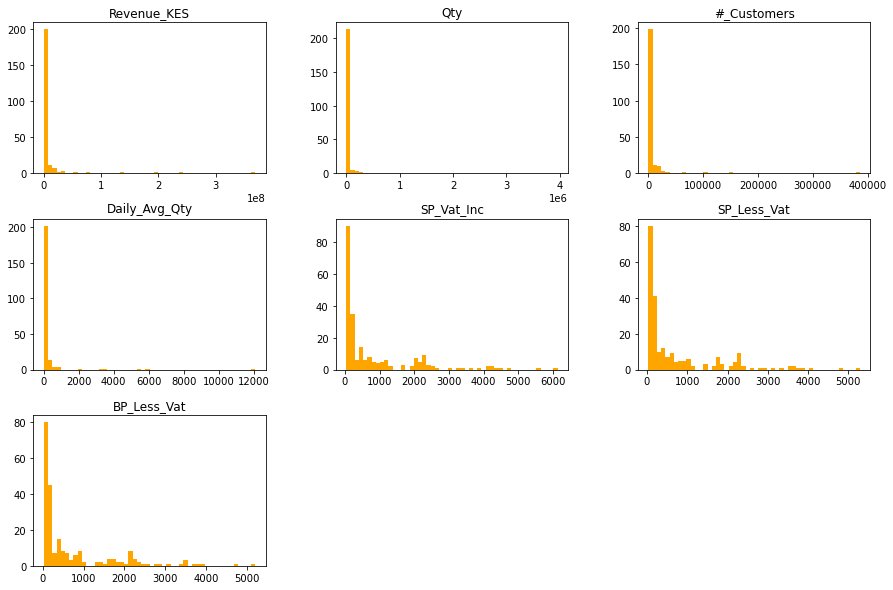

In [106]:
# Make histogram plots of the predictor variables to learm more about the shape of the data
df.hist(bins=50, grid=False, figsize=(15,10), color='orange')

In [107]:
# Create df2 from df with single column Revenue_KES
df2 = df[['Revenue_KES']].copy()
df2.head()

Revenue_KES
0  369462574.0
1  236835878.0
2  193367228.0
3  134354631.0
4   80081138.0

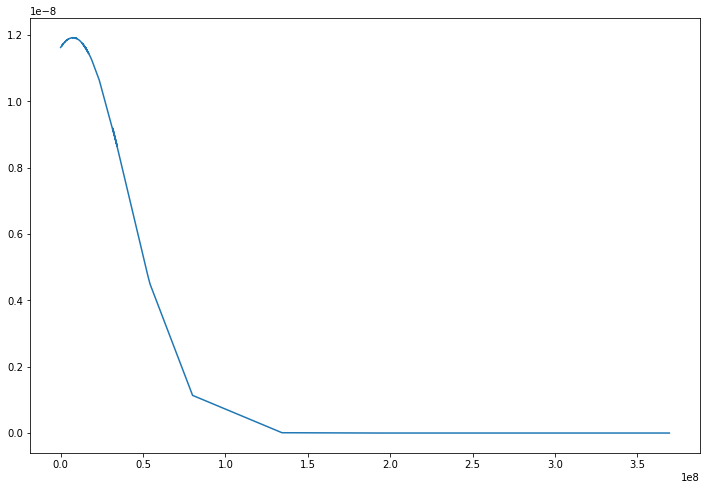

In [108]:
# Plot a normal distribution curve of Revenue variable from df2

fig = plt.figure()
 
fig.set_figheight(8)
fig.set_figwidth(12)

x_axis = df2['Revenue_KES']
# Calculating mean and standard deviation
mean = statistics.mean(x_axis)
sd = statistics.stdev(x_axis)
  
plt.plot(x_axis, norm.pdf(x_axis, mean, sd))
plt.show()


<AxesSubplot:ylabel='Density'>

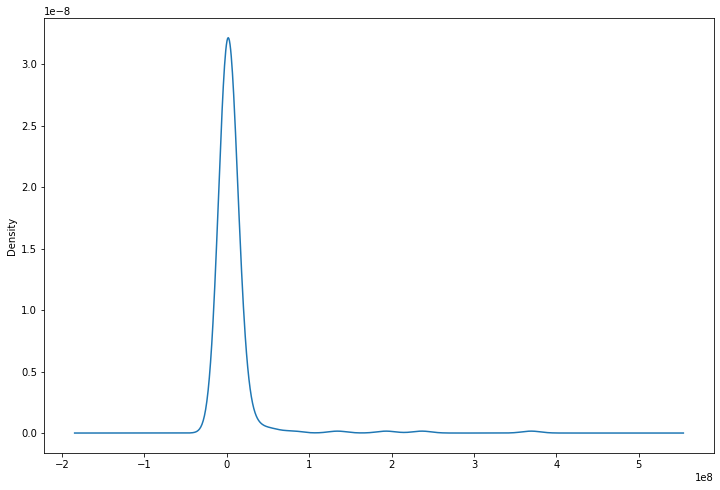

In [109]:
# Distribution of Revenue values
df2['Revenue_KES'].plot(kind='kde',figsize=(12,8))

### Defining the target variable
Generate mock data for target variable y for each SKU ( class 0 = inelastic class 1 = elastic). This is binary classification problem

In [110]:
X, y = make_classification(n_samples=229, n_classes=2, random_state=1)
# summarize observations by class label
counter = Counter(y)
print(counter)
# summarize dataset shape
#print(X.shape, y.shape)
print(y.shape)

Counter({0: 116, 1: 113})
(229,)


In [111]:
# Call the mock target vafriables
y

array([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1])

In [112]:
# Convert target variable y array into a pandas dataFrame
my_array = y
df3 = pd.DataFrame(my_array, columns = ['Target'])
df3.head(5)

Target
0       0
1       1
2       1
3       0
4       0

In [113]:
# Concatenate df and df3
df4 = df.join(df3['Target'])
df4.head()

Product_Code  Revenue_KES      Qty  #_Customers  Daily_Avg_Qty  SP_Vat_Inc  \
0        KQ263  369462574.0  3954936       385594       12094.61      108.37   
1        KQ469  236835878.0  1806875       153153        5525.61      131.07   
2        KQ479  193367228.0  1949351       147543        5961.32       99.20   
3        KQ480  134354631.0  1046833       105741        3201.32      128.34   
4        KQ525   80081138.0    45058        27251         138.21     2061.66   

   SP_Less_Vat  BP_Less_Vat  Target  
0        93.42        88.23       0  
1       131.07       128.41       1  
2        99.20        98.04       1  
3       128.34       125.79       0  
4      1777.29      1692.75       0

In [114]:
df4.shape

(229, 9)

### Modeling objective
The modeling objective is building a model that can be used to predict price elsaticity of a product using a given set of predictor variables. Price elasticity here is a binary variable, with two possible values or classes – 0 and 1. Model fitting involves trying to find a rule (model) that can identify a product's price elasticity.

### Linear or Nonlinear Classification
If there are 2 classes, then it is linear classification ( separated by a straight line). Otherwise it is nonlinear classification (separated by a triangle or polygon or by a curve). Generally the multiclass classification uses nonlinear classification. if the output is of multiclass then it is a nonlinear classification problem.

       Linear Classification                                      Nonlinear Classification

<img src="Linear.png" width=400, height=450 align='left'><img src="Nonlinear.jpeg" width=300, height=250 align='middle'>

### Examples of Linear Learning Algorithms
1. Linear Regression
2. Logistic Regression
3. Linear Discriminant Analysis

### Examples of Nonlinear Learning Algorithms
1. Classification and Regression Trees
2. Naive Bayes
3. K-Nearest Neighbhors
4. Learning Vector Quantization
5. Support Vector Machines

### Exploratory data analysis (EDA)

Exploratory data analysis (EDA) is a critical first step in any data analysis project, and is useful for the following reasons:

- Detecting errors in data;
- Validating our assumptions;
- Guide in the selection of appropriate models;
- Determining relationships among the explanatory variables; and
- Assessing the direction and size (roughly) of relationships between predictor/explanatory and response/target variables.

Basic EDA tools ("df.info()" and "df.describe()") help us to get a glimpse of the data we will be working with. Other useful EDA approaches include the preliminary screening of predictor variables to assess how they relate to the response variable(s). Now we demonstrate how we can explore differences in the distributions of features between the groups we are interested in.

In [115]:
# First extract the groups by target variable.
sub_gr = df4.groupby('Target')
sub_gr.first()
#sub_gr.head()

Product_Code  Revenue_KES      Qty  #_Customers  Daily_Avg_Qty  \
Target                                                                  
0             KQ263  369462574.0  3954936       385594       12094.61   
1             KQ469  236835878.0  1806875       153153        5525.61   

        SP_Vat_Inc  SP_Less_Vat  BP_Less_Vat  
Target                                        
0           108.37        93.42        88.23  
1           131.07       131.07       128.41

In [116]:
# First group class 0 = inelastic
sub_gr.get_group(0)

Product_Code  Revenue_KES      Qty  #_Customers  Daily_Avg_Qty  \
0          KQ263  369462574.0  3954936       385594       12094.61   
3          KQ480  134354631.0  1046833       105741        3201.32   
4          KQ525   80081138.0    45058        27251         138.21   
5          KQ524   54249309.0    14960         6844          47.64   
7          KQ281   31615482.0     6630         3927          22.10   
..           ...          ...      ...          ...            ...   
218       KQ1213       4921.0      133            1          66.50   
219        KQ715       3879.0       36           21           3.60   
223        KQ714       2000.0       20           11           3.33   
226       KQ1224        280.0        7            1           7.00   
227        KQ705          0.0        0            1           0.00   

     SP_Vat_Inc  SP_Less_Vat  BP_Less_Vat  Target  
0        108.37        93.42        88.23       0  
3        128.34       128.34       125.79       0  
4       2061.66      1777.29      1692.75       0  
5       4206.50      3626.29      3520.39       0  
7       5531.52      4768.47      4772.59       0  
..          ...          ...          ...     ...  
218       37.00        37.00        91.77       0  
219      125.00       107.76       102.05       0  
223      116.00       100.00        94.69       0  
226       40.00        40.00        95.83       0  
227         NaN          NaN          NaN       0  

[116 rows x 9 columns]

In [117]:
# Second group class 1 = elastic
sub_gr.get_group(1)

Product_Code  Revenue_KES      Qty  #_Customers  Daily_Avg_Qty  \
1          KQ469  236835878.0  1806875       153153        5525.61   
2          KQ479  193367228.0  1949351       147543        5961.32   
6          KQ580   52829986.0  1117884        63511        3560.14   
10         KQ228   23426436.0   239562        29046         762.94   
13         KQ470   17792353.0   135295        27931         415.02   
..           ...          ...      ...          ...            ...   
221       KQ1264       2767.0        1            1           1.00   
222       KQ1251       2740.0       26           14           2.60   
224       KQ1135       1545.0        3            3           1.50   
225       KQ1134        825.0        3            3           1.00   
228       KQ1131          0.0        0            1           0.00   

     SP_Vat_Inc  SP_Less_Vat  BP_Less_Vat  Target  
1        131.07       131.07       128.41       1  
2         99.20        99.20        98.04       1  
6         54.82        47.26        43.79       1  
10        97.79        97.79        92.48       1  
13       131.51       131.51       127.49       1  
..          ...          ...          ...     ...  
221     3210.00      2767.24      2536.42       1  
222      105.38       105.38       103.13       1  
224      515.00       515.00       500.00       1  
225      275.00       275.00       250.00       1  
228         NaN          NaN          NaN       1  

[113 rows x 9 columns]

In [118]:
# Distribution of Revenue_KES both classes
df4.Revenue_KES.head()

0    369462574.0
1    236835878.0
2    193367228.0
3    134354631.0
4     80081138.0
Name: Revenue_KES, dtype: float64

#### Are there any differences in the distribution of “Revenue_KES” between the two groups?

Text(0.5, 1.0, 'Class 1')

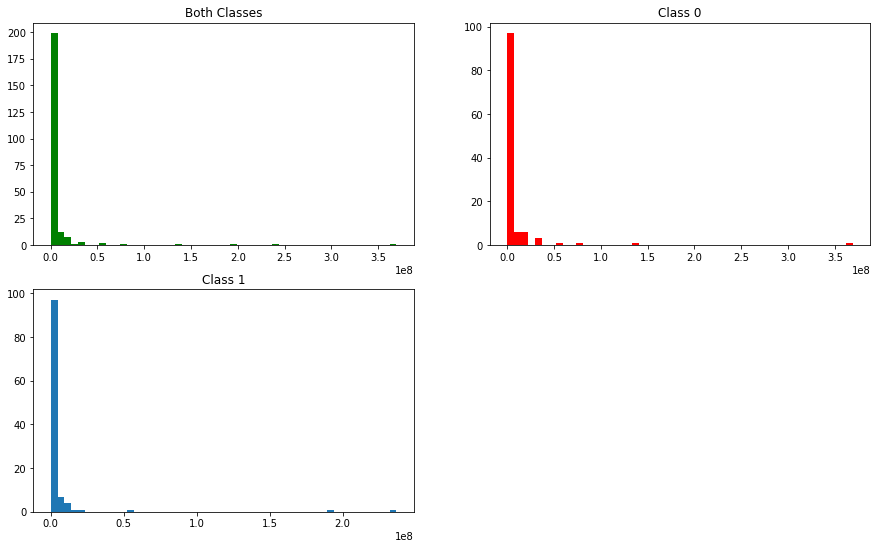

In [119]:
# Plot both Groups.
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 9) 
plt.rcParams['axes.titlesize'] = 'large'

plt.subplot(2,2,1)
_ = plt.hist(df4['Revenue_KES'].dropna(), bins=50, color='green')
plt.title('Both Classes')

# Plot Group 1.
plt.subplot(2,2,2)
_ = plt.hist(sub_gr.get_group(0) ['Revenue_KES'].dropna().values, bins=50, color='red')
plt.title('Class 0')

# Plot Group 2.
plt.subplot(2,2,3)
_ = plt.hist(sub_gr.get_group(1)['Revenue_KES'].dropna().values,bins=50)
plt.title('Class 1')

#### Are there any differences in the distribution of “#_Customers” between the two groups?

Text(0.5, 1.0, 'Class 1')

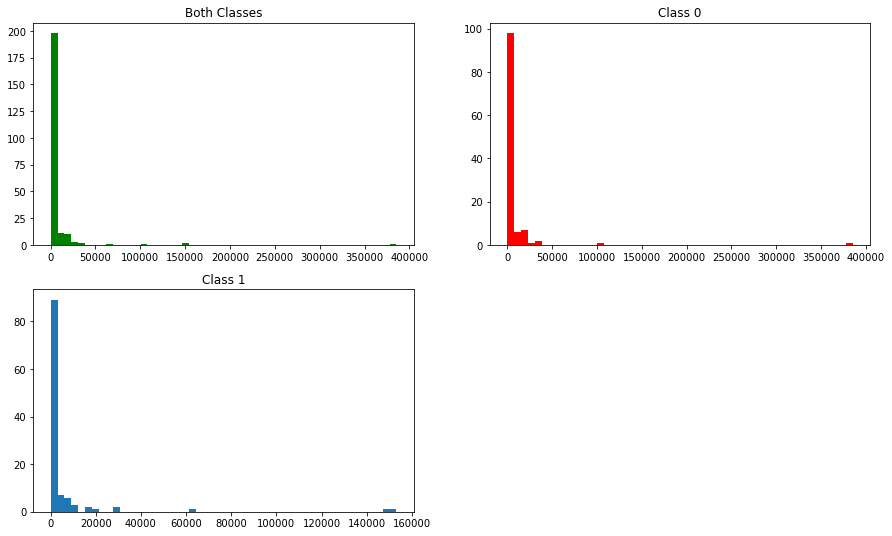

In [120]:
# Plot both Groups.
plt.subplot(2,2,1)
_ = plt.hist(df4['#_Customers'].dropna(), bins=50, color='green')
plt.title('Both Classes')

# Plot Group 1.
plt.subplot(2,2,2)
_ = plt.hist(sub_gr.get_group(0)['#_Customers'].dropna().values, bins=50, color='red')
plt.title('Class 0')

# Plot Group 2.
plt.subplot(2,2,3)
_ = plt.hist(sub_gr.get_group(1)['#_Customers'].dropna().values,bins=50)
plt.title('Class 1')

#### Are there any differences in the distribution of “Qty” between the two groups?

Text(0.5, 1.0, 'Class 1')

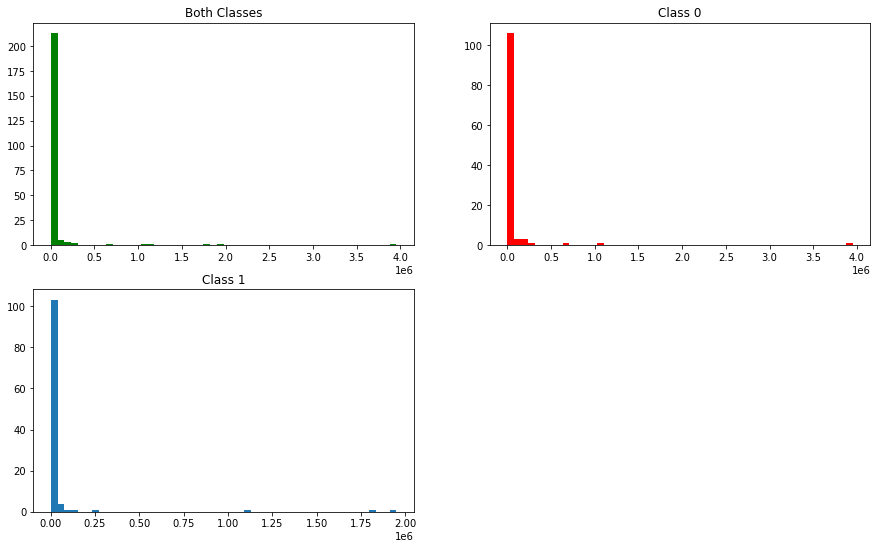

In [121]:
# Plot both Groups.
plt.subplot(2,2,1)
_ = plt.hist(df4['Qty'].dropna(), bins=50, color='green')
plt.title('Both Classes')

# Plot Group 1.
plt.subplot(2,2,2)
_ = plt.hist(sub_gr.get_group(0)['Qty'].dropna().values, bins=50, color='red')
plt.title('Class 0')

# Plot Group 2.
plt.subplot(2,2,3)
_ = plt.hist(sub_gr.get_group(1)['Qty'].dropna().values,bins=50)
plt.title('Class 1')

#### Are there any differences in the distribution of “Daily_Avg_Qty” between the two groups?

Text(0.5, 1.0, 'Class 1')

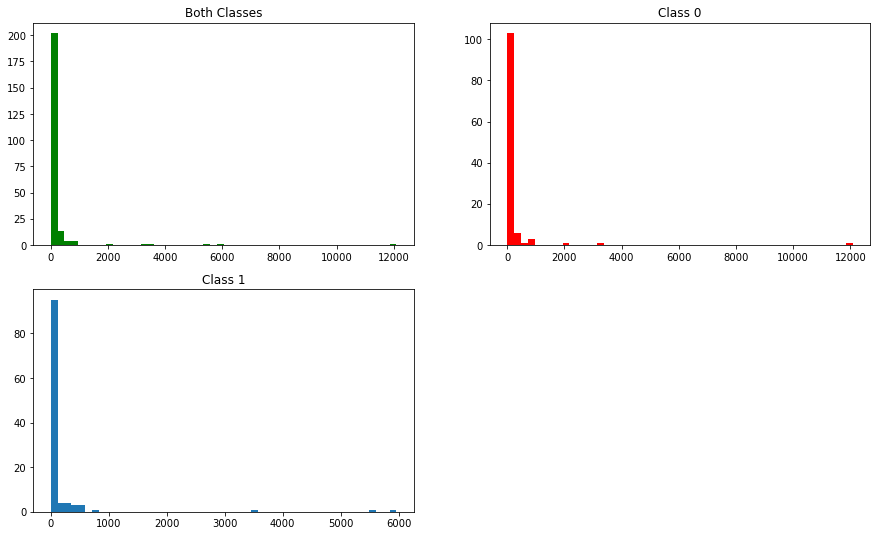

In [122]:
# Plot both Groups.
plt.subplot(2,2,1)
_ = plt.hist(df4['Daily_Avg_Qty'].dropna(), bins=50, color='green')
plt.title('Both Classes')

# Plot Group 1.
plt.subplot(2,2,2)
_ = plt.hist(sub_gr.get_group(0)['Daily_Avg_Qty'].dropna().values, bins=50, color='red')
plt.title('Class 0')

# Plot Group 2.
plt.subplot(2,2,3)
_ = plt.hist(sub_gr.get_group(1)['Daily_Avg_Qty'].dropna().values,bins=50)
plt.title('Class 1')

### Data Preprocessing
In order to make use of the machine learning tools, the data needs to be preprocessed. This involves a number of activities such as:
- Assigning numerical values to categorical data;
- Handling missing values; and
- Normalizing the features (so that features on small scales do not dominate when fitting a model to the data).
>**Note:** Small scales imply big value. For example, assume you are classifying people based on their physiological characteristics. A small-scale feature would be height (measured in meters) compared to weight (measured in kilograms).

First, filter the data set to only return records that have a non-null label. The target variable is a price-elasticity binary indicator that is in the column labeled "df.Target".

In [123]:
# Drop records with missing labels in the target variable.
df4 = df4[~df4.Target.isnull()]

In [124]:
# Review the target or response variable.
y = df4.Target.astype(int).values
y

array([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1])

In [125]:
# summarize observations by class label
counter = Counter(y)
print(counter)

Counter({0: 116, 1: 113})


### Drop non-informative columns

In [126]:
# Remove columns with reporting variables and response variable.
df4 = df4.drop(['Product_Code','SP_Vat_Inc','BP_Less_Vat','Target'], axis=1)
df4.head()

Revenue_KES      Qty  #_Customers  Daily_Avg_Qty  SP_Less_Vat
0  369462574.0  3954936       385594       12094.61        93.42
1  236835878.0  1806875       153153        5525.61       131.07
2  193367228.0  1949351       147543        5961.32        99.20
3  134354631.0  1046833       105741        3201.32       128.34
4   80081138.0    45058        27251         138.21      1777.29

In [127]:
# Identify features with constant values, or contain only missing values. 
to_drop = (df4.std().isnull()) |(abs(df4.std()) < 1e-6)

In [128]:
# Keep only the columns with variability.
to_keep = np.where(~to_drop.values)[0]
df4 = df4.iloc[:,to_keep]

In [129]:
# Assign predictors to a variable of ndarray (matrix) type .
X = df4.values
X[:5]

array([[3.69462574e+08, 3.95493600e+06, 3.85594000e+05, 1.20946100e+04,
        9.34200000e+01],
       [2.36835878e+08, 1.80687500e+06, 1.53153000e+05, 5.52561000e+03,
        1.31070000e+02],
       [1.93367228e+08, 1.94935100e+06, 1.47543000e+05, 5.96132000e+03,
        9.92000000e+01],
       [1.34354631e+08, 1.04683300e+06, 1.05741000e+05, 3.20132000e+03,
        1.28340000e+02],
       [8.00811380e+07, 4.50580000e+04, 2.72510000e+04, 1.38210000e+02,
        1.77729000e+03]])

In [130]:
# Check the class of array
type(X)

numpy.ndarray

In [131]:
# Display number of dimensions and items in the array (matrix)
# A 2-dimensional array of size 229 x 5.
X.shape

(229, 5)

In [132]:
# Display data type in the array (matrix)
X.dtype

dtype('float64')

### Imputing missing values
Data collected from experiments often contains missing values. Unfortunately, missing values can reduce the number of usable records for model building. In many cases, however, imputing the missing values can give better results than discarding affected samples. The effect of imputing missing values on model performance needs to be validated, because sometimes dropping affected rows can be more effective.
A number of strategies are available for imputing. With Scikit-Learn, missing values can be replaced by the mean, the median or the most frequent value. In our case we replace missing values using the mean of the valid values for that field. 

In [133]:
# Impute the missing values using the mean values of the respective features.
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(X)
X = imputer.transform(X)
X[:5]

array([[3.69462574e+08, 3.95493600e+06, 3.85594000e+05, 1.20946100e+04,
        9.34200000e+01],
       [2.36835878e+08, 1.80687500e+06, 1.53153000e+05, 5.52561000e+03,
        1.31070000e+02],
       [1.93367228e+08, 1.94935100e+06, 1.47543000e+05, 5.96132000e+03,
        9.92000000e+01],
       [1.34354631e+08, 1.04683300e+06, 1.05741000e+05, 3.20132000e+03,
        1.28340000e+02],
       [8.00811380e+07, 4.50580000e+04, 2.72510000e+04, 1.38210000e+02,
        1.77729000e+03]])

In [134]:
X.shape

(229, 5)

We use these two sets of the data ($X$ and $y$) to build a classifier, and contain they the following information:
> The array y contains the labels you want to predict, representing the price elsaticity of a product status as 0 (inelastic)  or 1 (elastic). The matrix X contains the features for all of the products (one column for one feature, and one line for one product).

#### Normalization
Normalize the data to center it around zero and transform it to a similiar scale to prevent variables in "small" units (and therefore high values) to dominate the classification unreasonably.

In [135]:
# Normalize the  data (center around 0 and scale to remove the variance).
scaler = preprocessing.StandardScaler()
Xs = scaler.fit_transform(X)
Xs[:5]

array([[10.83629981, 11.7705491 , 12.53984942, 11.71943953, -0.64155694],
       [ 6.86586603,  5.27865783,  4.84374144,  5.23850164, -0.60377109],
       [ 5.56454887,  5.70925022,  4.65799467,  5.66837064, -0.63575608],
       [ 3.79789392,  2.98165136,  3.27393288,  2.9453704 , -0.60651094],
       [ 2.17311312, -0.04592298,  0.67513355, -0.07667643,  1.04838868]])

### Feature selection
Before we build a classification model, we will perform variable screening to weed out variables that are either ill-conditioned or simply contain no information that will help in predicting the action of interest.  Feature variables that are constant, or contain only missing values, are the first target to remove as these do not add any information to the predictive model. 

A useful technique in preliminary variable screening is identifying features that have significant correlation to the target variable. We will focus on using the correlation matrix of the features and target variable.

In [136]:
# Define a function to plot a correlation matrix using df4
def correlation_matrix(df):
    import numpy as np
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Product Feature Correlation')
    labels = None
    # Add colorbar, and make sure to specify tick locations to match desired ticklabels.
    cbar = fig.colorbar(cax, ticks=[-1.1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6,.8,1])
    plt.show()

In [52]:
# Create and display the combined [Xs,y] array
z = pd.DataFrame(np.c_[Xs,y])
z.head()

0          1          2          3         4    5
0  10.836300  11.770549  12.539849  11.719440 -0.641557  0.0
1   6.865866   5.278658   4.843741   5.238502 -0.603771  1.0
2   5.564549   5.709250   4.657995   5.668371 -0.635756  1.0
3   3.797894   2.981651   3.273933   2.945370 -0.606511  0.0
4   2.173113  -0.045923   0.675134  -0.076676  1.048389  0.0

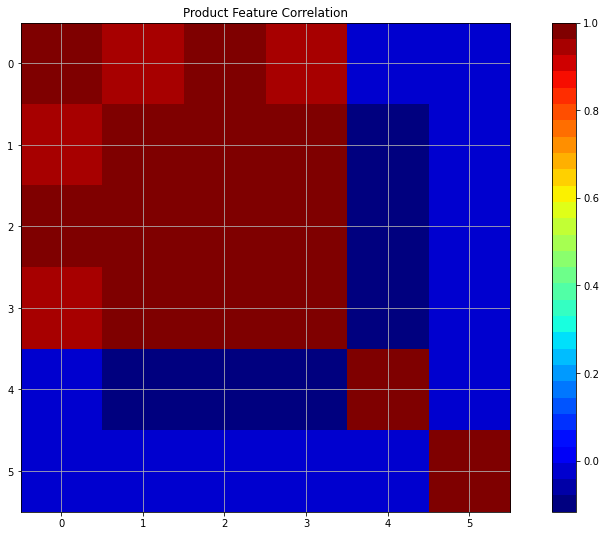

In [137]:
# Create and display the correlation matrix of the new array z using the function created above
correlation_matrix(z)

In [138]:
# Display the correlations between all features and the target variable
ycorr = pd.DataFrame(z.corr())
ycorr

0         1         2         3         4         5
0  1.000000  0.960395  0.967246  0.955586 -0.034286 -0.038877
1  0.960395  1.000000  0.983943  0.996905 -0.111177 -0.020391
2  0.967246  0.983943  1.000000  0.979562 -0.110345 -0.037753
3  0.955586  0.996905  0.979562  1.000000 -0.116788 -0.016252
4 -0.034286 -0.111177 -0.110345 -0.116788  1.000000 -0.019630
5 -0.038877 -0.020391 -0.037753 -0.016252 -0.019630  1.000000

<AxesSubplot:>

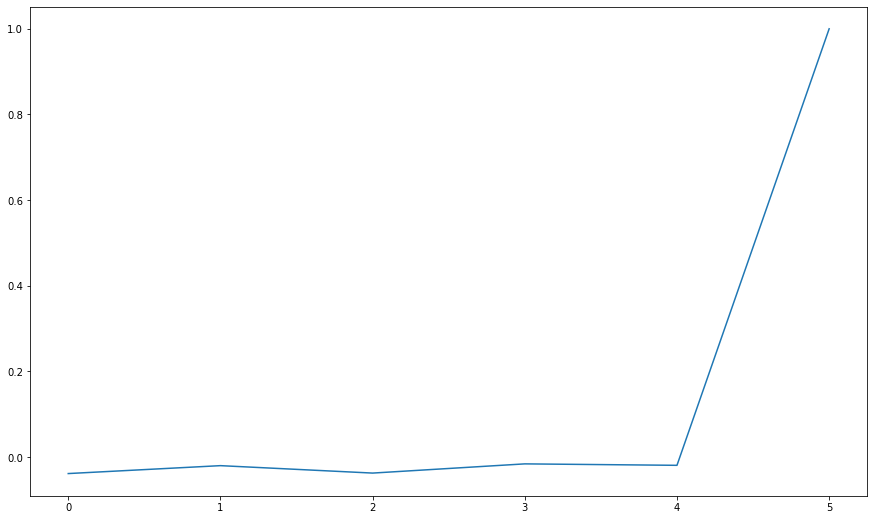

In [60]:
# Plot the correlations between all of the features and the target variable.
ycorr = pd.DataFrame(z.corr().values[:,-1], columns=['xycor'])
ycorr.xycor.plot(kind='line')

### Classification with cross-validation
Initially, we use the support vector machines (SVMs) learning algorithm to build the predictive model.SVMs are one of the most popular classification algorithms, and have an elegant way of transforming nonlinear data so that one can use a linear algorithm to fit a linear model to the data. 

Splitting data into **test** and **training** sets is crucial to avoid overfitting and, therefore, allows you to generalize to real, previously-unseen data. 

Cross-validation extends this idea further. Instead of having a single **train/test** split, we can specify so-called folds so that the data is divided into similarly-sized folds. Training occurs by taking all folds except one – referred to as the holdout sample. On the completion of the training, you test the performance of your fitted model using the holdout sample. 

The holdout sample is then thrown back with the rest of the other folds, and a different fold is pulled out as the new holdout sample. Training is repeated again with the remaining folds and we measure performance using the holdout sample. This process is repeated until each fold has had a chance to be a test or holdout sample. 

The expected performance of the classifier, called **cross-validation error**, is then simply an average of error rates computed on each holdout sample. This process is demonstrated below by first performing a standard train/test split, and then computing cross-validation error.

In [139]:
# Divide records in training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.3, random_state=2, stratify=y)

In [140]:
# summarize observations by class label
counter = Counter(y)
print(counter)
# summarize the dataset
print(Xs.shape, y.shape)

Counter({0: 116, 1: 113})
(229, 5) (229,)


In [141]:
# 30% y test set
y_test

array([0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 1])

In [142]:
y_test.shape

(69,)

In [143]:
# 70% y train set
y_train

array([1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1])

In [144]:
y_train.shape

(160,)

In [145]:
# 30% X train set
X_train[:5]

array([[-0.20016809, -0.15154317, -0.20039265,  0.31194306, -0.65539669],
       [-0.11915285, -0.14790141,  0.01462332, -0.1297256 , -0.42387433],
       [-0.17152879, -0.12484497, -0.15609154,  0.22162036, -0.64197845],
       [-0.19389532, -0.15363454, -0.11341283, -0.17770368, -0.6271953 ],
       [-0.21684621, -0.1742037 , -0.21264332,  0.07329577, -0.64005152]])

In [146]:
X_train.shape

(160, 5)

In [147]:
# 70% X test set
X_test[:5]

array([[-0.21306698, -0.17954697, -0.20138594, -0.20690687, -0.29036434],
       [-0.02841197, -0.0441157 ,  0.09580889, -0.0638803 , -0.59149696],
       [-0.21920126, -0.18054732, -0.21509346, -0.21094204, -0.40415343],
       [-0.22407586, -0.18200403, -0.2268806 , -0.1824492 , -0.52656352],
       [-0.2094186 , -0.18168065, -0.22327162, -0.21035995,  2.87224572]])

In [148]:
X_test.shape

(69, 5)

In [149]:
# Create an SVM classifier and train it on 70% of the data set.
clf = SVC(probability=True)
clf.fit(X_train, y_train)

# Analyze accuracy of predictions on 30% of the holdout test sample.
classifier_score = clf.score(X_test, y_test)
print('\nThe classifier accuracy score is {:.2f}\n'.format(classifier_score))


The classifier accuracy score is 0.52



To get a better measure of prediction accuracy (which we can use as a proxy for “goodness of fit” of the model), we can successively split the data into folds that you will use for training and testing:

In [150]:
# Get average of 5-fold cross-validation score using an SVC estimator.
from numpy import mean
from numpy import std
from numpy import var
n_folds = 5
# prepare the cross-validation procedure
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
cv_error = np.average(cross_val_score(clf, Xs, y, cv=cv))
print('\nThe {}-fold cross-validation accuracy score for this classifier is {:.2f}\n'.format(n_folds, cv_error))
# evaluate model
#scores = cross_val_score(clf, Xs, y, scoring='accuracy', cv=cv, n_jobs=-1)
scores = cross_val_score(clf, Xs, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# report performance
print('ROC-AUC: %.3f (%.3f)' % (mean(scores), std(scores)))


The 5-fold cross-validation accuracy score for this classifier is 0.44

ROC-AUC: 0.462 (0.059)


In [151]:
# Get average of 3-fold cross-validation score using an SVC estimator.
n_folds = 3
cv_error = np.average(cross_val_score(SVC(), Xs, y, cv=n_folds))
print('\nThe {}-fold cross-validation accuracy score for this classifier is {:.2f}\n'.format(n_folds, cv_error))


The 3-fold cross-validation accuracy score for this classifier is 0.48



### Receiver operating characteristic (ROC) curve. 

In statistical modeling and machine learning, a commonly-reported performance measure of model accuracy is Area Under the Curve (AUC), where, by “curve”, the ROC curve is implied. ROC is a term that originated from the Second World War and was used by radar engineers (it had nothing to do with machine learning or pattern recognition).

To understand what information the ROC curve conveys, consider the so-called confusion matrix that essentially is a two-dimensional table where the classifier model is on one axis (vertical), and ground truth is on the other (horizontal) axis, as shown below. Either of these axes can take two values (as depicted). A cell in the table is then an intersection where the conditions on each of the dimensions hold. For example, in the top left cell, the model condition is "A" and the ground truth is also "A". The count of instances where these two conditions are true (for a specific data point) is captured, hence the label “True positive”. The same logic applies to the rest of the cells. The total of the counts in these cells should therefore equal the number of data instances in the data set under consideration.


~~~~
                        Model says "+"     Model says  "-"

      Actual: "+"       True positive   |   False negative
                      -------------------------------------
      Actual: "-"       False positive  |   True negative
  
~~~~



In an ROC curve, you plot “True Positive Rate” on the Y-axis and “False Positive Rate” on the X-axis, where the values “true positive”, “false negative”, “false positive”, and “true negative” are events (or their probabilities) as described above. The rates are defined according to the following:

> True positive rate (or sensitivity)}:  **tpr = tp / (tp + fn)**

> False positive rate:&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;                   **fpr = fp / (fp + tn)**

> True negative rate (or specificity):   **tnr = tn / (fp + tn)**

In all definitions, the denominator is a row margin in the above confusion matrix. You can therefore express the true positive rate (tpr) as the probability that the model says "+" when the real value is indeed "+" (i.e., a conditional probability). However, this does not tell you how likely you are to be correct when calling "+" (i.e., the probability of a true positive, conditioned on the test result being "+").

To interpret the ROC correctly, consider what the points that lie along the diagonal represent. For these situations, there is an equal chance of "+" and "-" happening. Therefore, this is not that different from making a prediction by tossing of an unbiased coin. Put simply, the classification model is random.

For the points above the diagonal, **tpr** > **fpr**, and the model says that you are in a zone where you are performing better than random. For example, assume **tpr ** = 0.6 and **fpr** = 0.2.Then, the probability of being in the true positive group is $(0.6 / (0.6 + 0.2)) = 75\%$. Furthermore, holding **fpr** constant, it is easy to see that the more vertically above the diagonal you are positioned, the better the classification model.

<h2>What is a confusion matrix?</h2><p>In <a href="/machine-learning-glossary-and-terms/machine-learning">machine learning</a>, a confusion matrix is an nxn matrix such that each row represents the true classification of a given piece of data and each column represents the predicted classification (or vise versa). By looking at a confusion matrix, one can determine the accuracy of the model by looking at the values on the diagonal to determine the number of correct classifications - a good model will have high values along the diagonal and low values off the diagonal.  Further, one can tell where the model is struggling by assessing the highest values not on the diagonal. &nbsp;Together, these analyses are useful to identify cases where the accuracy may be high but the model is consistently misclassifying the same data.</p>

In [152]:
# The confusion matrix helps visualize the performance of the algorithm.
y_hat = clf.fit(X_train, y_train).predict(X_test)
cm = metrics.confusion_matrix(y_test, y_hat)

print(cm)

[[ 6 29]
 [ 4 30]]


In [153]:
# Actual
y_test

array([0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 1])

In [154]:
# Model says
y_hat

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1])

<Figure size 1440x720 with 0 Axes>

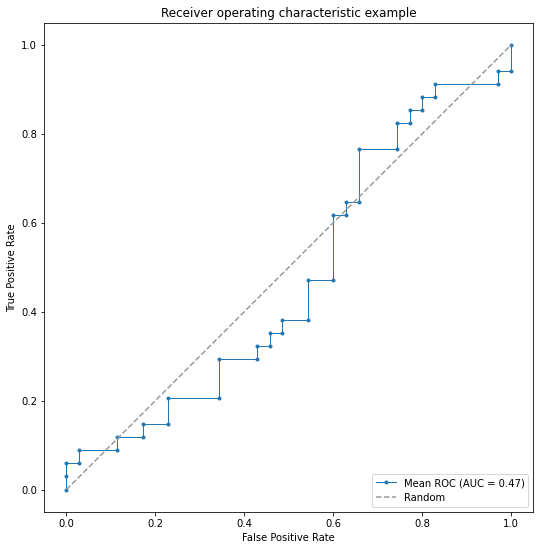

In [155]:
# Plot the receiver operating characteristic curve (ROC).
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 9) 
plt.rcParams['axes.titlesize'] = 'large'
plt.figure(figsize=(20,10))
fg, ax = plt.subplots(1)
probas_ = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:,1])
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, marker='.', lw=1, label='Mean ROC (AUC = %0.2f)' % (roc_auc))
ax.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
ax.legend(loc="lower right")
ax.axes.set_aspect(1)

### Optimal classifier parameters

### SVM Kernel Functions
SVM algorithms use a set of mathematical functions that are defined as the kernel. The function of kernel is to take data as input and transform it into the required form. Different SVM algorithms use different types of kernel functions. These functions can be different types. For example linear, nonlinear, polynomial, radial basis function (RBF), and sigmoid.

In the above examples we made use of the "``SVC()``" function (using default parameters). Usually, you would want to optimize the setting of these parameters for a given problem, as these are learned by the algorithm during the training phase. In the case of support vector classifiers, these parameters include the choice of the kernel,
the kernel parameters (Gaussian kernel: $\gamma$; Polynomial kernel: $d$), as well as the penalty for misclassification ($C$). 

Tuning parameters for an optimal solution is inherently difficult. A popular approach is to perform a search over the grid (defined across the various parameters to be optimized for). The grid search function is illustrated next. This illustration considers how to optimize over two parameters – $C$ (misclassification cost), and $\gamma$ (The RBF kernel parameter).

This example illustrates the effect of the parameters gamma and C of the Radial Basis Function (RBF) kernel SVM.

<p>C and Gamma are the parameters for a nonlinear support vector machine (SVM) with a Gaussian radial basis function kernel. A standard SVM seeks to find a margin that separates all positive and negative examples.</p>

<p>C is a regularization parameter that controls the trade off between the achieving a low training error and a low testing error that is the ability to generalize your classifier to unseen data. The gamma parameter defines how far the influence of a single training example reaches, with low values meaning 'far' and high values meaning 'close'.</p>

In [156]:
# Train classifiers.
# np.logspace() function returns numbers spaced evenly on a log scale.
# In practice, a logarithmic grid from -3 to 3 is usually sufficient.
param_grid = {'C': np.logspace(-3, 2, 6), 'gamma': np.logspace(-3, 2, 6)}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])})

In [157]:
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 0.001, 'gamma': 0.001} with a score of 0.49


In [158]:
grid.best_estimator_.probability = True
clf = grid.best_estimator_

In [160]:
y_hat = clf.fit(X_train, y_train).predict(X_test)
cm = metrics.confusion_matrix(y_test, y_hat)

print(cm)

[[35  0]
 [34  0]]


### Using other classifiers

The SVM classifier is only one of the classifiers that you have at your disposal. There are other classification methods implemented in Scikit-learn (as well as Mlxtend) that you can easily use. These include:

- Decision trees with ``tree.DecisionTreeClassifier()``;
- K-nearest neighbors with ``neighbors.KNeighborsClassifier()``;
- Random forests with ``ensemble.RandomForestClassifier()``;
- Perceptron (both gradient and stochastic gradient) with ``mlxtend.classifier.Perceptron``; and 
- Multilayer perceptron network (both gradient and stochastic gradient) with ``mlxtend.classifier.MultiLayerPerceptron``.

It is important to understand the underlying technique, as well as the corresponding implementation, in order to correctly interpret the output, or tune the estimator parameters. The following example illustrates the use of some of these classifiers on the data set, using the above-mentioned libraries.

In [161]:
# Create an instance of random forest classifier, fit the data, and assess performance on test data.
clf_rf = ensemble.RandomForestClassifier(n_estimators=200,n_jobs=-1,max_depth=5 )    
n_folds = 3
cv_error = np.average(cross_val_score(clf_rf, 
                                      X_train, 
                                      y_train, 
                                      cv=n_folds))
clf_rf.fit(X_train, y_train)
print ('\nThe {}-fold cross-validation accuracy score for this classifier is {:.2f}\n'.format(n_folds, cv_error))


The 3-fold cross-validation accuracy score for this classifier is 0.41



In [162]:
# Create an instance of logistic regression classifier, fit the data, and assess performance on test data.
clf_logreg = linear_model.LogisticRegression(C=1e5)    
n_folds = 3
cv_error = np.average(cross_val_score(clf_logreg, 
                                      X_train, 
                                      y_train, 
                                      cv=n_folds))
clf_logreg.fit(X_train, y_train)
print('\nThe {}-fold cross-validation accuracy score for this classifier is {:.2f}\n'.format(n_folds, cv_error)) 


The 3-fold cross-validation accuracy score for this classifier is 0.39



In [163]:
# Create an instance of decision tree classifier, fit the data, and assess performance on test data.
clf_tree = tree.DecisionTreeClassifier()
n_folds = 3
cv_error = np.average(cross_val_score(clf_tree, 
                                      X_train, 
                                      y_train, 
                                      cv=n_folds))
clf_tree = clf_tree.fit(X_train, y_train)
print('\nThe {}-fold cross-validation accuracy score for this classifier is {:.2f}\n'.format(n_folds, cv_error))


The 3-fold cross-validation accuracy score for this classifier is 0.42



In [164]:
# Create an instance of multilayer perceptron classifier (gradient descent), fit the data, and assess performance on test data.
clf_nn1 = MLP(hidden_layers=[40],l2=0.00,l1=0.0,epochs=150,eta=0.05,momentum=0.1,decrease_const=0.0,minibatches=1,random_seed=1,print_progress=3)
clf_nn1 = clf_nn1.fit(X_train, y_train)
clf_nn1.score(X_test, y_test)

Iteration: 150/150 | Cost 0.94 | Elapsed: 0:00:00 | ETA: 0:00:000

0.4927536231884058

In [165]:
# Create an instance of multilayer perceptron classifier (stochastic gradient descent), fit the data, and assess performance on test data.
clf_nn2 = MLP(hidden_layers=[40],l2=0.00,l1=0.0,epochs=50,eta=0.05,momentum=0.1,decrease_const=0.0,minibatches=len(y_train),random_seed=1,print_progress=3)
clf_nn2 = clf_nn2.fit(X_train, y_train)
clf_nn2.score(X_test, y_test)

Iteration: 50/50 | Cost 0.42 | Elapsed: 0:00:00 | ETA: 0:00:000

0.5072463768115942

<Figure size 1440x720 with 0 Axes>

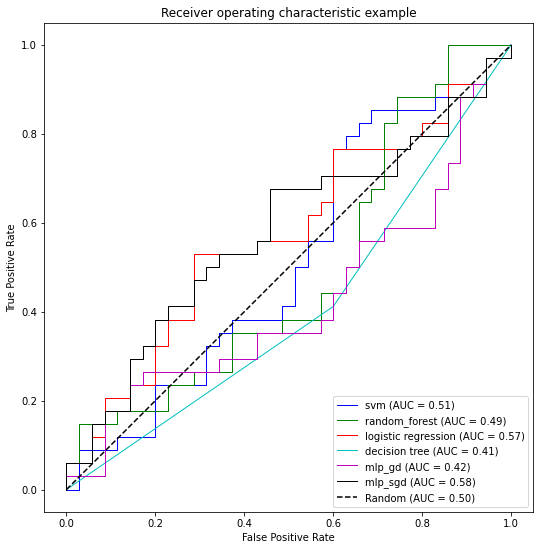

In [166]:
# Plot the results.
colors = ['b', 'g', 'r','c','m','k','y']
classifiers = ['svm','random_forest', 'logistic regression', 'decision tree', 'mlp_gd', 'mlp_sgd']
_ = plt.figure(figsize=(20,10))
f, ax = plt.subplots(1)

for i, cl in enumerate([clf, clf_rf, clf_logreg, clf_tree,clf_nn1, clf_nn2]):
    probas_ = cl.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    _ = ax.plot(fpr, tpr, lw=1,color=colors[i], label=classifiers[i]+' (AUC = %0.2f)' % (roc_auc))
    
_ = ax.plot([0, 1], [0, 1], '--', color=colors[i], label='Random (AUC = 0.50)')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])   
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.axes.set_aspect(1)
_ = ax.legend(loc="lower right")